In [1]:
import sys
import os
sys.path.append("../") 
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import json
import requests
import pickle
import omnivida_loader as ov
import omnivida_util as ovu
import statsmodels.api         as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from io import StringIO
from IPython.display import Image, SVG
from graphviz import Source
from sklearn.tree import export_graphviz
import pydotplus
import xgboost as xgb
from xgboost import XGBClassifier

### Loading Datasets

In [2]:
adherence, adherence_change = ov.get_adherence_dataset()
med_treat = ov.get_medical_treatments_dataset()
bio_meds = ov.get_bio_meds_dataset()
med_coll_issues = ov.get_med_collec_issues_dataset()

### Setting dataset

In [3]:
# Adherencia Data Set
adherence_change.id_patient =  adherence_change.id_patient.astype('str')
fields = ['id_patient', 'survey_date', 'category', 
                 'qualitative_result', 'qualitative_result_change', 
                 'days_since_last_control', 'ongoing_adherence_percentage', 'num_reports']
adherence_change_df = adherence_change[fields]

In [4]:
# Biological medicines
bio_meds.product_name = bio_meds.product_name.astype(int)
bio_meds.generic_name = bio_meds.generic_name.astype(int)

In [5]:
# Medical collecting issues
med_coll_issues.drop(columns='Observations', inplace=True)
med_coll_issues.novelty_type = med_coll_issues.novelty_type.astype(int)
med_coll_issues.event_type = med_coll_issues.event_type.astype('category')

In [6]:
# Medical Treatments
med_treat['quantity'] = med_treat['quantity'].fillna(0)
med_treat.drop(columns=['diagnosis','medicine_name'], inplace=True)
med_treat['regional_EPS'] = med_treat['regional_EPS'].astype('category')
med_treat['medicine_code'] = med_treat['medicine_code'].astype('category')
med_treat['diagnosis_code'] = med_treat['diagnosis_code'].astype('category')


### MERGING DATAFRAME


In [7]:
adh_bio_coll = adherence_change_df.merge(bio_meds, on='id_patient', how='left')
adh_bio_coll1 = adh_bio_coll.merge(med_coll_issues, on='id_patient', how='left')



### MERGIND DATASETS USING FUNCTION

In [8]:
# Merging adherence and biological medicines 
merge_adh_bio = ovu.merge_on_closest_date(df1=adherence_change_df, 
                                          df2=bio_meds, 
                                          date_field_df1='survey_date', 
                                          date_field_df2='record_date', 
                                          merge_on='id_patient')

In [9]:
merge_adh_bio

,id_patient,survey_date,category,qualitative_result,qualitative_result_change,days_since_last_control,ongoing_adherence_percentage,num_reports,days_since_record_date,record_date,product_name,generic_name,quantity
0,500547,2019-10-11,A,1.0,0.0,211.0,100.0,3,90.0,2019-07-13,1,0,2
1,500547,2019-12-09,A,1.0,0.0,59.0,100.0,4,149.0,2019-07-13,1,0,2
2,500547,2020-01-16,A,1.0,0.0,38.0,100.0,5,187.0,2019-07-13,1,0,2
3,500547,2020-03-25,A,1.0,0.0,69.0,100.0,6,256.0,2019-07-13,1,0,2
4,500547,2020-05-08,A,1.0,0.0,44.0,100.0,7,300.0,2019-07-13,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2101,1999536,2018-08-08,A,1.0,NaN,NaN,100.0,1,29.0,2018-07-10,1,0,1
2102,1999536,2020-02-22,A,1.0,0.0,563.0,100.0,2,24.0,2020-01-29,1,0,1
2103,1999629,2018-04-06,A,1.0,NaN,NaN,100.0,1,31.0,2018-03-06,0,0,2
2104,1999629,2018-05-04,A,1.0,0.0,28.0,100.0,2,0.0,2018-05-04,0,0,2


In [10]:
merge_adh_bio.rename(columns={'days_since_record_date':'days_since_last_delivery',
                             'quantity':'bio_quantity'}, inplace=True)

period = 30
aclq_timely = merge_adh_bio[merge_adh_bio.days_since_last_delivery <= period]
aclq_late = merge_adh_bio[merge_adh_bio.days_since_last_delivery > period]
aclq_timely 


,id_patient,survey_date,category,qualitative_result,qualitative_result_change,days_since_last_control,ongoing_adherence_percentage,num_reports,days_since_last_delivery,record_date,product_name,generic_name,bio_quantity
5,500588,2019-04-26,A,1.0,NaN,NaN,100.000000,1,6.0,2019-04-20,1,0,3
6,502989,2018-10-03,M,0.0,-1.0,421.0,38.461538,13,23.0,2018-09-10,1,0,3
8,506808,2018-04-09,M,1.0,0.0,397.0,91.666667,12,23.0,2018-03-17,0,0,2
21,514102,2018-01-30,A,0.0,-1.0,74.0,66.666667,3,7.0,2018-01-23,0,0,4
23,524006,2018-10-03,A-,1.0,0.0,404.0,76.923077,13,12.0,2018-09-21,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2100,1998401,2018-01-29,A-,1.0,1.0,504.0,66.666667,12,14.0,2018-01-15,0,0,3
2101,1999536,2018-08-08,A,1.0,NaN,NaN,100.000000,1,29.0,2018-07-10,1,0,1
2102,1999536,2020-02-22,A,1.0,0.0,563.0,100.000000,2,24.0,2020-01-29,1,0,1
2104,1999629,2018-05-04,A,1.0,0.0,28.0,100.000000,2,0.0,2018-05-04,0,0,2


In [11]:
aclq_timely_summary = pd.DataFrame()
for (patient, survey_date), df in aclq_timely.groupby(['id_patient', 'survey_date']):
    aclq_timely_summary = aclq_timely_summary.append({
                'id_patient': patient,
                'survey_date': survey_date,
                'bio_quantity': df.bio_quantity.sum(),
                'days_since_last_delivery': df.iloc[-1]['days_since_last_delivery']
            }, ignore_index=True)

In [12]:
aclq_timely_summary

,bio_quantity,days_since_last_delivery,id_patient,survey_date
0,1.0,26.0,1000768,2020-02-04
1,1.0,4.0,1000768,2020-04-20
2,2.0,0.0,1004538,2020-03-25
3,2.0,1.0,1007268,2019-11-28
4,1.0,2.0,1007268,2020-04-16
...,...,...,...,...
1133,1.0,0.0,982570,2020-04-27
1134,2.0,19.0,989121,2018-01-30
1135,3.0,12.0,993957,2019-05-21
1136,3.0,13.0,993957,2020-04-01


In [13]:
# Merging adherence_bio Part 3
merge_adh_bio = adherence_change_df.merge(aclq_timely_summary, how='left', on=['id_patient', 'survey_date'])
merge_adh_bio.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4765 entries, 0 to 4764
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   id_patient                    4765 non-null   object        
 1   survey_date                   4765 non-null   datetime64[ns]
 2   category                      4765 non-null   category      
 3   qualitative_result            4765 non-null   float64       
 4   qualitative_result_change     3925 non-null   float64       
 5   days_since_last_control       3925 non-null   float64       
 6   ongoing_adherence_percentage  4765 non-null   float64       
 7   num_reports                   4765 non-null   int64         
 8   bio_quantity                  1138 non-null   float64       
 9   days_since_last_delivery      1138 non-null   float64       
dtypes: category(1), datetime64[ns](1), float64(6), int64(1), object(1)
memory usage: 377.1+ KB


In [14]:
merge_adh_bio['qualitative_result_change'] = merge_adh_bio['qualitative_result_change'].fillna(0)
merge_adh_bio['days_since_last_control'] = merge_adh_bio['days_since_last_control'].fillna(0)
merge_adh_bio['bio_quantity'] = merge_adh_bio['bio_quantity'].fillna(0)
merge_adh_bio['days_since_last_delivery'] = merge_adh_bio['days_since_last_delivery'].fillna(0)

In [15]:
merge_all_medicines = merge_adh_bio.copy()
merge_all_medicines.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4765 entries, 0 to 4764
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   id_patient                    4765 non-null   object        
 1   survey_date                   4765 non-null   datetime64[ns]
 2   category                      4765 non-null   category      
 3   qualitative_result            4765 non-null   float64       
 4   qualitative_result_change     4765 non-null   float64       
 5   days_since_last_control       4765 non-null   float64       
 6   ongoing_adherence_percentage  4765 non-null   float64       
 7   num_reports                   4765 non-null   int64         
 8   bio_quantity                  4765 non-null   float64       
 9   days_since_last_delivery      4765 non-null   float64       
dtypes: category(1), datetime64[ns](1), float64(6), int64(1), object(1)
memory usage: 377.1+ KB


In [16]:
# Merging adherence_biological medicines and collecting issues 
merge_adh_coll = ovu.merge_on_closest_date(df1=adherence_change_df, 
                                          df2=med_coll_issues, 
                                          date_field_df1='survey_date', 
                                          date_field_df2='register_date', 
                                          merge_on='id_patient')

In [17]:
merge_adh_coll.columns

Index(['id_patient', 'survey_date', 'category', 'qualitative_result',
       'qualitative_result_change', 'days_since_last_control',
       'ongoing_adherence_percentage', 'num_reports',
       'days_since_register_date', 'novelty_type', 'event_type',
       'register_date'],
      dtype='object')

In [18]:
merge_adh_coll.rename(columns={'days_since_register_date':'days_since_last_coll_issue'}, inplace=True)

period = 30
aclq_timely_c = merge_adh_coll[merge_adh_coll.days_since_last_coll_issue <= period]
aclq_late_c = merge_adh_coll[merge_adh_coll.days_since_last_coll_issue > period]
aclq_timely_c

aclq_timely_summary_c = pd.DataFrame()
for (patient, survey_date), df in aclq_timely_c.groupby(['id_patient', 'survey_date']):
    aclq_timely_summary_c = aclq_timely_summary_c.append({
        'id_patient': patient,
        'survey_date': survey_date,
        'novelty_type': df.novelty_type.sum(),
        'days_since_last_coll_issue': df.iloc[-1]['days_since_last_coll_issue']
    }, ignore_index=True)
    
merge_adh_coll = merge_all_medicines.merge(aclq_timely_summary_c, how='left', on=['id_patient', 'survey_date'])
merge_adh_coll.info();


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4765 entries, 0 to 4764
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   id_patient                    4765 non-null   object        
 1   survey_date                   4765 non-null   datetime64[ns]
 2   category                      4765 non-null   category      
 3   qualitative_result            4765 non-null   float64       
 4   qualitative_result_change     4765 non-null   float64       
 5   days_since_last_control       4765 non-null   float64       
 6   ongoing_adherence_percentage  4765 non-null   float64       
 7   num_reports                   4765 non-null   int64         
 8   bio_quantity                  4765 non-null   float64       
 9   days_since_last_delivery      4765 non-null   float64       
 10  days_since_last_coll_issue    924 non-null    float64       
 11  novelty_type                  

In [19]:
merge_adh_coll.head();

In [20]:
merge_adh_coll['days_since_last_coll_issue'] = merge_adh_coll['days_since_last_coll_issue'].fillna(0)
merge_adh_coll['novelty_type'] = merge_adh_coll['novelty_type'].fillna(0)
merge_adh_coll.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4765 entries, 0 to 4764
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   id_patient                    4765 non-null   object        
 1   survey_date                   4765 non-null   datetime64[ns]
 2   category                      4765 non-null   category      
 3   qualitative_result            4765 non-null   float64       
 4   qualitative_result_change     4765 non-null   float64       
 5   days_since_last_control       4765 non-null   float64       
 6   ongoing_adherence_percentage  4765 non-null   float64       
 7   num_reports                   4765 non-null   int64         
 8   bio_quantity                  4765 non-null   float64       
 9   days_since_last_delivery      4765 non-null   float64       
 10  days_since_last_coll_issue    4765 non-null   float64       
 11  novelty_type                  

In [21]:
# Merging adherence_biological medicines_collecting issues and medical treatments
merge_adh__med = ovu.merge_on_closest_date(df1=adherence_change_df, 
                                          df2=med_treat, 
                                          date_field_df1='survey_date', 
                                          date_field_df2='released_date', 
                                          merge_on='id_patient')


In [22]:
biologicals_codes = ['M029140', 'M029751', 'M029551', 'M029157', 'M029631', 'M021755']
merge_adh__med1 = merge_adh__med[~merge_adh__med['medicine_code'].isin(biologicals_codes)]
merge_adh__med1

merge_adh__med1.rename(columns={'days_since_released_date':'days_since_last_non_biological_delivery'}, inplace=True)

period = 30
aclq_timely_m = merge_adh__med1[merge_adh__med1.days_since_last_non_biological_delivery <= period]
aclq_late_m = merge_adh__med1[merge_adh__med1.days_since_last_non_biological_delivery > period]
aclq_timely_m

aclq_timely_summary_m = pd.DataFrame()
for (patient, survey_date), df in aclq_timely_m.groupby(['id_patient', 'survey_date']):
    aclq_timely_summary_m = aclq_timely_summary_m.append({
        'id_patient': patient,
        'survey_date': survey_date,
        'quantity_non_biological': df.quantity.sum(),
        'days_since_last_non_biological_delivery': df.iloc[-1]['days_since_last_non_biological_delivery']
    }, ignore_index=True)
    
merge_all2 = merge_adh_coll.merge(aclq_timely_summary_m, how='left', on=['id_patient', 'survey_date'])
merge_all2.info()

C:\Users\Jhon\anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4765 entries, 0 to 4764
Data columns (total 14 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   id_patient                               4765 non-null   object        
 1   survey_date                              4765 non-null   datetime64[ns]
 2   category                                 4765 non-null   category      
 3   qualitative_result                       4765 non-null   float64       
 4   qualitative_result_change                4765 non-null   float64       
 5   days_since_last_control                  4765 non-null   float64       
 6   ongoing_adherence_percentage             4765 non-null   float64       
 7   num_reports                              4765 non-null   int64         
 8   bio_quantity                             4765 non-null   float64       
 9   days_since_last_delivery                 

In [23]:
merge_all2['days_since_last_non_biological_delivery'] = merge_all2['days_since_last_non_biological_delivery'].fillna(0)
merge_all2['quantity_non_biological'] = merge_all2['quantity_non_biological'].fillna(0)
merge_all2.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4765 entries, 0 to 4764
Data columns (total 14 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   id_patient                               4765 non-null   object        
 1   survey_date                              4765 non-null   datetime64[ns]
 2   category                                 4765 non-null   category      
 3   qualitative_result                       4765 non-null   float64       
 4   qualitative_result_change                4765 non-null   float64       
 5   days_since_last_control                  4765 non-null   float64       
 6   ongoing_adherence_percentage             4765 non-null   float64       
 7   num_reports                              4765 non-null   int64         
 8   bio_quantity                             4765 non-null   float64       
 9   days_since_last_delivery                 

In [24]:
merge_modelable = merge_all2.copy()

In [25]:
merge_modelable

,id_patient,survey_date,category,qualitative_result,qualitative_result_change,days_since_last_control,ongoing_adherence_percentage,num_reports,bio_quantity,days_since_last_delivery,days_since_last_coll_issue,novelty_type,days_since_last_non_biological_delivery,quantity_non_biological
0,500547,2016-07-11,A,1.0,0.0,0.0,100.0,1,0.0,0.0,0.0,0.0,0.0,0.0
1,500547,2019-03-14,A,1.0,0.0,976.0,100.0,2,0.0,0.0,0.0,0.0,0.0,0.0
2,500547,2019-10-11,A,1.0,0.0,211.0,100.0,3,0.0,0.0,0.0,0.0,0.0,0.0
3,500547,2019-12-09,A,1.0,0.0,59.0,100.0,4,0.0,0.0,0.0,0.0,0.0,0.0
4,500547,2020-01-16,A,1.0,0.0,38.0,100.0,5,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4760,1999536,2018-08-08,A,1.0,0.0,0.0,100.0,1,1.0,29.0,0.0,0.0,0.0,0.0
4761,1999536,2020-02-22,A,1.0,0.0,563.0,100.0,2,1.0,24.0,0.0,0.0,0.0,0.0
4762,1999629,2018-04-06,A,1.0,0.0,0.0,100.0,1,0.0,0.0,29.0,0.0,0.0,1.0
4763,1999629,2018-05-04,A,1.0,0.0,28.0,100.0,2,2.0,0.0,0.0,0.0,0.0,0.0


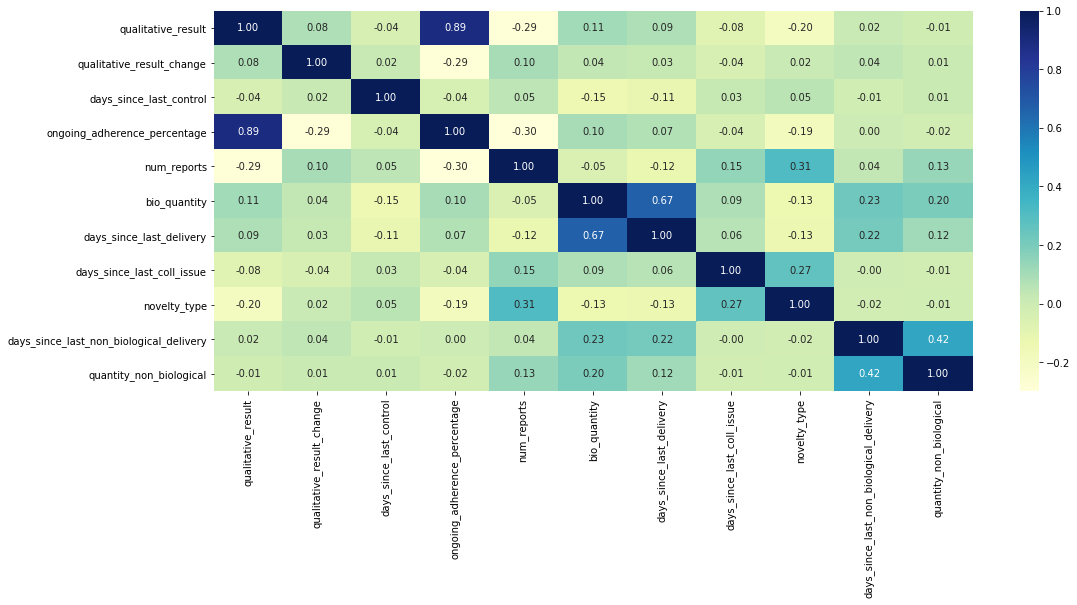

In [26]:
plt.figure(figsize=(17,7))
sns.heatmap(merge_modelable.groupby('id_patient').mean().corr(), annot=True, cmap="YlGnBu",fmt=".2f")

## Model Training:

In [27]:
def train(self):
    """Train two models: one Random forest classifier and one based on XGBoost"""
    if not self.rforest and not self.xgboost:
        covariates = self.data.columns[~self.data.columns.isin(['id_patient', 'qualitative_result', 'survey_date', 'birthdate', 'num_reports'])]
        print('> Training Random Forest classifier...')
        self.rforest = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=0)
        self.rforest.fit(self.data[covariates], self.data['qualitative_result'])
        y_pred_rf = self.rforest.predict(self.data[covariates])
        accuracy_rf = accuracy_score(self.data['qualitative_result'], y_pred_rf)
        print("> Done. Accuracy: %.2f%%" % (accuracy_rf * 100.0))

        print('> Training XGBoost classifier...')
        params={
            'reg_alpha': 23, 
            'max_depth': 8, 
            'learning_rate': 0.01, 
            'gamma': 1.0
        }
        self.xgboost = XGBClassifier(random_state=0, booster='gbtree', **params)
        self.xgboost.fit(self.data[covariates], self.data['qualitative_result'])
        y_pred_xg = self.xgboost.predict(self.data[covariates])
        predictions_xg = [round(value) for value in y_pred_xg]
        accuracy_xg = accuracy_score(self.data['qualitative_result'], predictions_xg)
        print("> Done. Accuracy: %.2f%%" % (accuracy_xg * 100.0))

    return (self.rforest, self.xgboost)

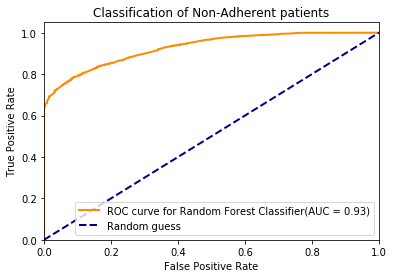

In [28]:
#Model using all covariates:

covariates1 = merge_modelable.columns[~merge_modelable.columns.isin(['id_patient', 
                                                                      'qualitative_result',
                                                                       'category',
                                                                       'survey_date',
                                                                    'days_since_last_control',
                                                                    'qualitative_result_change'])]
depth = 7

clf = DecisionTreeClassifier(max_depth = depth)
clf = clf.fit(merge_modelable[covariates1], merge_modelable['qualitative_result'])

clf_rf = RandomForestClassifier(n_estimators=100, max_depth=depth, random_state=0)
clf_rf.fit(merge_modelable[covariates1], merge_modelable['qualitative_result'])
clf_rf_probas = clf_rf.predict_proba(merge_modelable[covariates1])

roc_p = roc_curve(merge_modelable['qualitative_result'], clf_rf_probas[:,1])
auc_p = auc_p = auc( roc_p[0], roc_p[1] )

plt.figure()
line_width = 2
plt.plot(roc_p[0], roc_p[1], color='darkorange', lw=line_width,
         label=f"ROC curve for Random Forest Classifier(AUC = {auc_p:0.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of Non-Adherent patients')
plt.legend(loc='lower right')
plt.show()

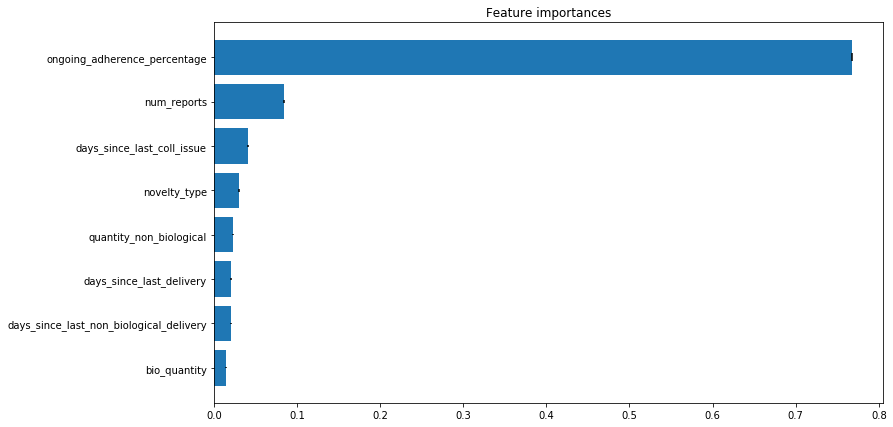

In [29]:
importances = clf_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_],
             axis=0)
indices = np.argsort(importances)

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(12,7))
plt.title("Feature importances")
plt.barh(merge_modelable[covariates1].columns[indices], importances[indices], yerr=std[indices], align="center")
plt.show()


### Model using all covariates but num_reports  and ongoing_adherence_percentage

In [30]:
covariates2 = merge_modelable.columns[~merge_modelable.columns.isin(['id_patient', 'qualitative_result', 'survey_date', 'birthdate', 'num_reports','days_since_last_control',
                                                                    'qualitative_result_change','category','ongoing_adherence_percentage'])]
covariates2

Index(['bio_quantity', 'days_since_last_delivery',
       'days_since_last_coll_issue', 'novelty_type',
       'days_since_last_non_biological_delivery', 'quantity_non_biological'],
      dtype='object')

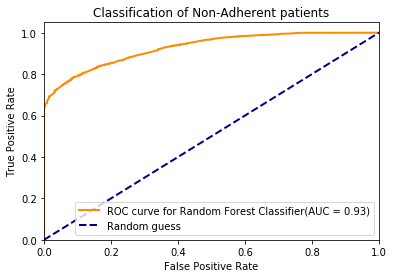

In [31]:
#Model using all covariates but num_reports and ongoing_adherence_percentage.

depth = 7

clf2 = DecisionTreeClassifier(max_depth = depth)
clf2 = clf.fit(merge_modelable[covariates2], merge_modelable['qualitative_result'])

clf_rf2 = RandomForestClassifier(n_estimators=100, max_depth=depth, random_state=0)
clf_rf2.fit(merge_modelable[covariates2], merge_modelable['qualitative_result'])
clf_rf_probas2 = clf_rf2.predict_proba(merge_modelable[covariates2])

roc_p2 = roc_curve(merge_modelable['qualitative_result'], clf_rf_probas[:,1])
auc_p2 = auc_p2 = auc( roc_p2[0], roc_p2[1] )

plt.figure()
line_width = 2
plt.plot(roc_p2[0], roc_p2[1], color='darkorange', lw=line_width,
         label=f"ROC curve for Random Forest Classifier(AUC = {auc_p2:0.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of Non-Adherent patients')
plt.legend(loc='lower right')
plt.show()

### Train and test sets

In [32]:
merge_modelable_train = merge_modelable[merge_modelable['survey_date'] < "2020-01-01"]
merge_modelable_test = merge_modelable[merge_modelable['survey_date'] > "2019-12-31"]

display(merge_modelable_train)
display(merge_modelable_test)

,id_patient,survey_date,category,qualitative_result,qualitative_result_change,days_since_last_control,ongoing_adherence_percentage,num_reports,bio_quantity,days_since_last_delivery,days_since_last_coll_issue,novelty_type,days_since_last_non_biological_delivery,quantity_non_biological
0,500547,2016-07-11,A,1.0,0.0,0.0,100.000000,1,0.0,0.0,0.0,0.0,0.0,0.0
1,500547,2019-03-14,A,1.0,0.0,976.0,100.000000,2,0.0,0.0,0.0,0.0,0.0,0.0
2,500547,2019-10-11,A,1.0,0.0,211.0,100.000000,3,0.0,0.0,0.0,0.0,0.0,0.0
3,500547,2019-12-09,A,1.0,0.0,59.0,100.000000,4,0.0,0.0,0.0,0.0,0.0,0.0
7,500588,2019-04-26,A,1.0,0.0,0.0,100.000000,1,3.0,6.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4759,1998401,2018-01-29,A-,1.0,1.0,504.0,66.666667,12,3.0,14.0,14.0,0.0,0.0,0.0
4760,1999536,2018-08-08,A,1.0,0.0,0.0,100.000000,1,1.0,29.0,0.0,0.0,0.0,0.0
4762,1999629,2018-04-06,A,1.0,0.0,0.0,100.000000,1,0.0,0.0,29.0,0.0,0.0,1.0
4763,1999629,2018-05-04,A,1.0,0.0,28.0,100.000000,2,2.0,0.0,0.0,0.0,0.0,0.0


,id_patient,survey_date,category,qualitative_result,qualitative_result_change,days_since_last_control,ongoing_adherence_percentage,num_reports,bio_quantity,days_since_last_delivery,days_since_last_coll_issue,novelty_type,days_since_last_non_biological_delivery,quantity_non_biological
4,500547,2020-01-16,A,1.0,0.0,38.0,100.000000,5,0.0,0.0,0.0,0.0,0.0,0.0
5,500547,2020-03-25,A,1.0,0.0,69.0,100.000000,6,0.0,0.0,0.0,0.0,0.0,0.0
6,500547,2020-05-08,A,1.0,0.0,44.0,100.000000,7,0.0,0.0,0.0,0.0,0.0,0.0
75,526049,2020-03-06,A,1.0,0.0,1176.0,100.000000,5,2.0,4.0,0.0,0.0,1.0,90.0
76,526049,2020-03-19,A,1.0,0.0,13.0,100.000000,6,1.0,3.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4711,1990453,2020-05-06,A-,1.0,0.0,168.0,72.727273,11,4.0,6.0,0.0,0.0,0.0,0.0
4726,1995390,2020-04-21,M,1.0,0.0,1091.0,85.714286,7,1.0,4.0,0.0,0.0,14.0,30.0
4744,1997065,2020-02-19,M,1.0,0.0,498.0,85.714286,14,2.0,25.0,0.0,0.0,2.0,1.0
4747,1997825,2020-01-16,M,1.0,1.0,168.0,66.666667,3,2.0,27.0,0.0,0.0,0.0,0.0


In [33]:
#Decision tree with covariates 1.
clf_new = DecisionTreeClassifier(max_depth = depth)
clf_new = clf_new.fit(merge_modelable_train[covariates1], merge_modelable_train['qualitative_result'])

y_pred_train = clf_new.predict(merge_modelable_train[covariates1])
y_pred_test = clf_new.predict(merge_modelable_test[covariates1])

print(f"Accuracy in training set: {accuracy_score(merge_modelable_train['qualitative_result'], y_pred_train)}")
print(f"Accuracy in the other samples: {accuracy_score(merge_modelable_test['qualitative_result'], y_pred_test)}")



Accuracy in training set: 0.8529076396807298
Accuracy in the other samples: 0.9289473684210526


In [34]:
#Decision tree with covariates 2.
clf_new2 = DecisionTreeClassifier(max_depth = depth)
clf_new2 = clf_new.fit(merge_modelable_train[covariates2], merge_modelable_train['qualitative_result'])

y_pred_train2 = clf_new.predict(merge_modelable_train[covariates2])
y_pred_test2 = clf_new.predict(merge_modelable_test[covariates2])

print(f"Accuracy in training set: {accuracy_score(merge_modelable_train['qualitative_result'], y_pred_train2)}")
print(f"Accuracy in the other samples: {accuracy_score(merge_modelable_test['qualitative_result'], y_pred_test2)}")

Accuracy in training set: 0.793842645381984
Accuracy in the other samples: 0.9210526315789473


In [35]:
#Random forest with covariates 1.
clf_rf_new = RandomForestClassifier(n_estimators=100, max_depth=depth, random_state=0)
clf_rf_new.fit(merge_modelable_train[covariates1], merge_modelable_train['qualitative_result'])

y_pred_trainr = clf_rf_new.predict(merge_modelable_train[covariates1])
y_pred_testr = clf_rf_new.predict(merge_modelable_test[covariates1])

print(f"Accuracy in training set: {accuracy_score(merge_modelable_train['qualitative_result'], y_pred_trainr)}")
print(f"Accuracy in the other samples: {accuracy_score(merge_modelable_test['qualitative_result'], y_pred_testr)}")

Accuracy in training set: 0.8629418472063854
Accuracy in the other samples: 0.9342105263157895


In [36]:


#Random forest with covariates 2.
clf_rf_new2 = RandomForestClassifier(n_estimators=100, max_depth=depth, random_state=0)
clf_rf_new2.fit(merge_modelable_train[covariates2], merge_modelable_train['qualitative_result'])

y_pred_trainr2 = clf_rf_new2.predict(merge_modelable_train[covariates2])
y_pred_testr2 = clf_rf_new2.predict(merge_modelable_test[covariates2])

print(f"Accuracy in training set: {accuracy_score(merge_modelable_train['qualitative_result'], y_pred_trainr2)}")
print(f"Accuracy in the other samples: {accuracy_score(merge_modelable_test['qualitative_result'], y_pred_testr2)}")



Accuracy in training set: 0.7913340935005702
Accuracy in the other samples: 0.9289473684210526


### xgboost

In [37]:
#fit model on training data with covariates 2.
xgb_model= XGBClassifier(max_depth=depth, random_state=0, booster='gbtree')
xgb_model.fit(merge_modelable_train[covariates2], merge_modelable_train['qualitative_result'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [38]:
y_pred2 = xgb_model.predict(merge_modelable_test[covariates2])
predictions2 = [round(value) for value in y_pred2]

accuracy = accuracy_score(merge_modelable_test['qualitative_result'], predictions2)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 91.32%


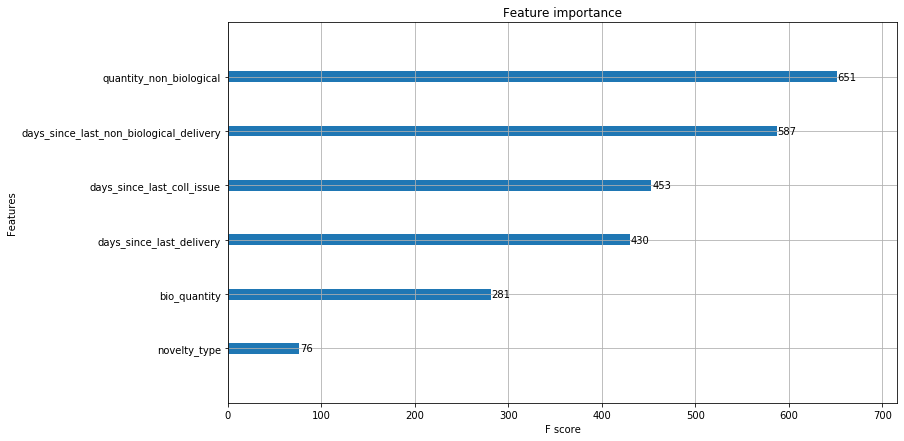

In [39]:

fig2, ax2 = plt.subplots(figsize=(12,7))
xgb.plot_importance(xgb_model, ax=ax2)

In [40]:
params_grid = {  
    'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05],
    'max_depth': [5,6,7,8,9,10,11,12],
    'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0],
    'reg_alpha': [20, 21, 22, 23, 24, 25]
}

search_sk = RandomizedSearchCV(xgb_model, params_grid, cv = 5) # 5 fold cross validation
search_sk.fit(merge_modelable_test[covariates1], merge_modelable_test['qualitative_result'])

# best parameters
print(search_sk.best_params_)
print(search_sk.best_score_)

{'reg_alpha': 22, 'max_depth': 6, 'learning_rate': 0.04, 'gamma': 0.5}
0.9315789473684211


In [41]:
xgb_model_new = XGBClassifier(random_state=0, booster='gbtree', **search_sk.best_params_)
xgb_model_new.fit(merge_modelable_train[covariates2], merge_modelable_train['qualitative_result']);

In [42]:
y_pred_new = xgb_model_new.predict(merge_modelable_test[covariates2])
predictions_new = [round(value) for value in y_pred_new]

accuracy = accuracy_score(merge_modelable_test['qualitative_result'], predictions_new)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 93.16%


In [43]:
xgb_model_new = XGBClassifier(random_state=0, booster='gbtree', **search_sk.best_params_)
xgb_model_new.fit(merge_modelable_train[covariates1], merge_modelable_train['qualitative_result'])
y_pred_new = xgb_model_new.predict(merge_modelable_test[covariates1])
predictions_new = [round(value) for value in y_pred_new]

accuracy = accuracy_score(merge_modelable_test['qualitative_result'], predictions_new)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 92.63%


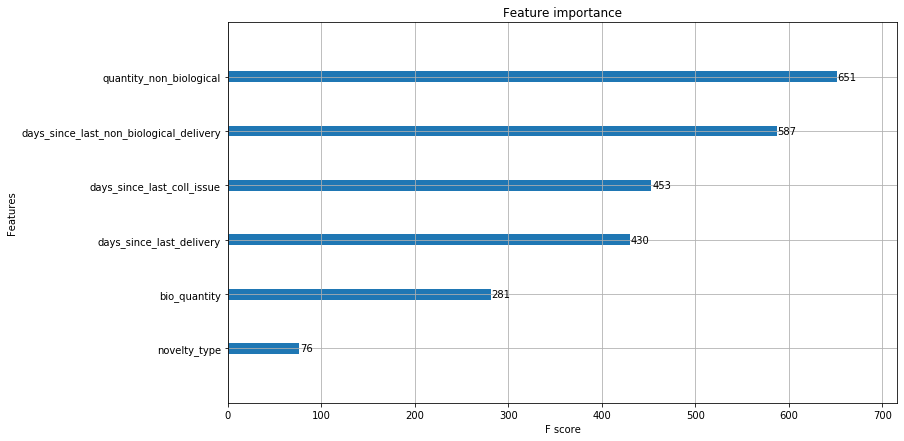

In [44]:
fig, ax = plt.subplots(figsize=(12,7))
xgb.plot_importance(xgb_model, ax=ax)

In [45]:


xgb_model_full = XGBClassifier(random_state=0, booster='gbtree', **search_sk.best_params_)
xgb_model_full.fit(merge_modelable[covariates2], merge_modelable['qualitative_result'])

y_pred_new = xgb_model_full.predict(merge_modelable[covariates2])
predictions_new = [round(value) for value in y_pred_new]

accuracy = accuracy_score(merge_modelable['qualitative_result'], predictions_new)
print("Accuracy: %.2f%%" % (accuracy * 100.0))



Accuracy: 79.35%


### Evaluate these three models with cross validation

In [46]:
def cv_roc_tree(X, y, n_split, algo='Tree', depth=10, params={}):
    
    cv = StratifiedKFold(n_split)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    for train, test in cv.split(X, y):
        if algo == 'Tree':
            clf = DecisionTreeClassifier()
        elif algo == 'forest':
            clf = RandomForestClassifier(n_estimators=100, max_depth=depth, random_state=0)
        else:
            clf = XGBClassifier(random_state=0, booster='gbtree', verbosity=0, **params)
            
                
        clf = clf.fit(X.iloc[train], y.iloc[train])
        probas_ = clf.predict_proba(X.iloc[test])
        
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:,1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
    
    return tprs, aucs, mean_fpr

Text(0.5, 1.0, 'Tree-based Classification of Non-adherent patients: 5-fold Cross-validation')

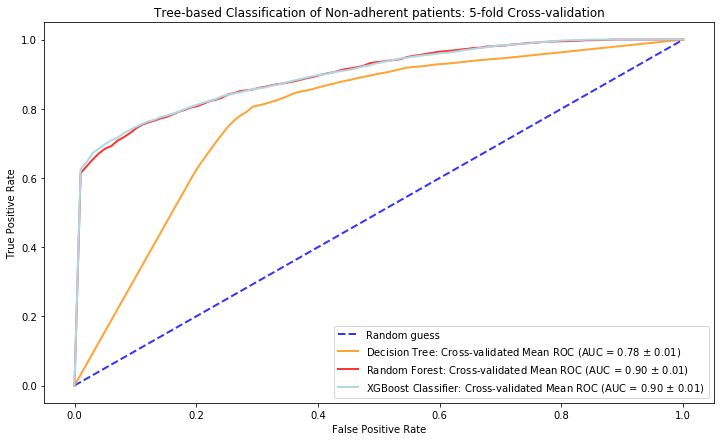

In [47]:
k_folds = 5
tprs_t, aucs_t, mean_fpr_t = cv_roc_tree(merge_modelable[covariates1], merge_modelable['qualitative_result'], k_folds, depth=depth)
tprs_f, aucs_f, mean_fpr_f = cv_roc_tree(merge_modelable[covariates1], merge_modelable['qualitative_result'], k_folds, algo='forest', depth=depth)
tprs_x, aucs_x, mean_fpr_x = cv_roc_tree(merge_modelable[covariates1], merge_modelable['qualitative_result'], k_folds, algo='xgboost', params=search_sk.best_params_)

plt.figure(figsize=(12,7))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='blue', label='Random guess', alpha=.8)

mean_tpr_t = np.mean(tprs_t, axis=0)
mean_tpr_f = np.mean(tprs_f, axis=0)
mean_tpr_x = np.mean(tprs_x, axis=0)
mean_tpr_t[-1] = 1.0
mean_tpr_f[-1] = 1.0
mean_tpr_x[-1] = 1.0

mean_auc_t = auc(mean_fpr_t, mean_tpr_t)
mean_auc_f = auc(mean_fpr_f, mean_tpr_f)
mean_auc_x = auc(mean_fpr_x, mean_tpr_x)
std_auc_t = np.std(aucs_t)
std_auc_f = np.std(aucs_f)
std_auc_x = np.std(aucs_x)

plt.plot(mean_fpr_t, mean_tpr_t, color='darkorange', lw=2, alpha=.8,
         label=f"Decision Tree: Cross-validated Mean ROC (AUC = {mean_auc_t:0.2f} $\pm$ {std_auc_t:0.2f})")
plt.plot(mean_fpr_f, mean_tpr_f, color='red', lw=2, alpha=.8,
         label=f"Random Forest: Cross-validated Mean ROC (AUC = {mean_auc_f:0.2f} $\pm$ {std_auc_f:0.2f})")
plt.plot(mean_fpr_x, mean_tpr_x, color='lightblue', lw=2, alpha=1.,
         label=f"XGBoost Classifier: Cross-validated Mean ROC (AUC = {mean_auc_x:0.2f} $\pm$ {std_auc_x:0.2f})")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title(f'Tree-based Classification of Non-adherent patients: {k_folds}-fold Cross-validation')



### Trying HumanisticModel class

In [48]:
from pharmaceutical_model import pharmaceuticalModel

ph = pharmaceuticalModel()

# train models
rf, xg = ph.train()

# dump models to disk
ph.dump_models()

C:\Users\Jhon\anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


> Training Random Forest classifier...
> Done. Accuracy: 80.57%
> Training XGBoost classifier...
> Done. Accuracy: 79.35%

> Random forest classifier dumped into ./pharmaceutical_rfores.pkl.
> XGBoost classifier dumped into ./pharmaceutical_xgboost.pkl.


### Loading models from pkl files

In [50]:
import pickle

loaded_rforest = pickle.load(open('pharmaceutical_rforest.pkl','rb'))
loaded_xgboost = pickle.load(open('pharmaceutical_xgboost.pkl','rb'))

In [52]:
loaded_rforest.predict_proba(merge_modelable_test[covariates2])[:,0]

array([0.18999139, 0.18999139, 0.18999139, ..., 0.22962263, 0.16450952,
       0.18417037])

In [53]:
loaded_xgboost.predict(merge_modelable_test[covariates2])

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [ ]:
bi_fr_wb_adherence_test['qualitative_result'].to_numpy()

In [ ]:


loaded_xgboost.predict(bi_fr_wb_adherence_test[covariates2])



In [ ]:
bi_fr_wb_adherence_test['qualitative_result'].to_numpy()